In [2]:
from utils import helpers  # helper functions

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from model_interfaces import base_model
import data, dice
import model as dice_model

In [3]:
dataset = pd.read_csv('csv/adultdataset.csv')
dataset.head()

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0


In [4]:
target = dataset["income"]
# Split data into train and test
datasetX = dataset.drop("income", axis=1)
x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)

numerical = ["age", "hours_per_week"]
categorical = x_train.columns.difference(numerical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('regressor', LGBMRegressor())])
model = clf.fit(x_train, y_train)

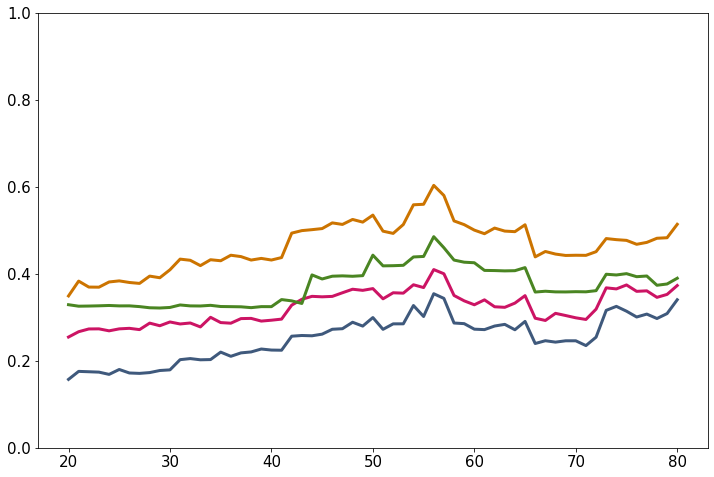

In [63]:
class_workclass = [[0.0912, 0.0632, 0.7186, 0.1270], [0.1272, 0.0788, 0.6776, 0.1164], [0.18, 0.09, 0.50, 0.23], [0.0940, 0.0871, 0.7165, 0.1024]]
class_education = [[0.081, 0.070, 0.057, 0.078, 0.010, 0.063, 0.431, 0.21], [0.10, 0.11, 0.14, 0.11, 0.017, 0.12, 0.34, 0.063], [0.0958, 0.1970, 0.1922, 0.2019, 0.0038, 0.2157, 0.0200, 0.0736], [0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]
class_marital_status = [[0.03, 0.01, 0.87, 0.04, 0.05], [0.0087, 0.0115, 0.9365, 0.0230, 0.0203], [0.02, 0.05, 0.83, 0.05, 0.05], [0.2366, 0.2720, 0.0000, 0.2355, 0.2559]]
class_occupation = [[0, 0.12, 0.08, 0.09, 0.08, 0.63], [0, 0.23, 0.04, 0.05, 0.07, 0.61], [0, 0.51, 0.12, 0.12, 0.21, 0.04], [0, 0.18, 0.07, 0.08, 0.08, 0.59]]
class_race = [[0.1842, 0.8158], [0.1033, 0.8967], [0.3016, 0.6984], [0.1137, 0.8863]]
class_gender = [[0.4111, 0.5889], [0.9131, 0.0869], [0.5266, 0.4734], [0.9114, 0.0886]]
colors = ["#3F597C", "#CC1464", "#CC7400", "#4A8522"]
np.random.seed(1998)

class_list = []
for i in range(4):
    pred_list = []
    for hw in range(20,81):
        temp = []
        for j in range(1000):
            # セグメント i
            workclass = np.random.choice(['Government','Other/Unknown','Private','Self-Employed'], p=class_workclass[i])
            education = np.random.choice(['Assoc', 'Bachelors', 'Doctorate', 'Masters', 'School', 'Prof-school', 'HS-grad', 'Some-college'], p=class_education[i])
            marital_status = np.random.choice(['Separated', 'Divorced', 'Married', 'Widowed', 'Single'], p=class_marital_status[i])
            occupation = np.random.choice(['Other/Unknown', 'Professional', 'Sales', 'Service', 'White-Collar', 'Blue-Collar'], p=class_occupation[i])
            race = np.random.choice(['Other', 'White'], p=class_race[i])
            gender = np.random.choice(['Female', 'Male'], p=class_gender[i])

            test_instance = pd.DataFrame.from_dict({'age': 29,
                            'workclass': workclass,
                            'education': education,
                            'marital_status': marital_status,
                            'occupation': occupation,
                            'race': race,
                            'gender': gender,
                            'hours_per_week': hw}, orient='index').T

            temp.append(model.predict(test_instance)[0])
        pred_list.append(np.mean(temp))
    class_list.append(pred_list)

plt.figure(figsize=(12,8))
for i in range(4):
    plt.plot(range(20,81), class_list[i], linewidth=3, color=colors[i])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.xlabel("hours_per_week")
#plt.ylabel("High income probability")
plt.ylim(0.0, 1.0)
#plt.savefig("images/lca_ga_extra_segment_all_hw.png")
plt.show()